#  Merge: Sentimento + Retornos do BOVA11

Este notebook realiza o merge entre os dados de sentimento diário e os retornos logarítmicos do BOVA11.

## Objetivos:
1.  Carregar dados de sentimento e retornos
2.  Realizar merge inteligente por data
3.  Criar variáveis defasadas (lags)
4.  Análise preliminar de correlação
5.  Salvar dataset final para análise estatística

---

## 1. Setup & Importações

In [1]:
import sys
import os

# Adiciona o diretório raiz ao path
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Módulos do projeto
from src.sentiment.daily_aggregation import (
    merge_with_market_data,
    create_lagged_features,
    calculate_sentiment_correlation
)

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(" Importações concluídas!")

 Importações concluídas!


## 2. Carregamento dos Dados

### 2.1 Dados de Sentimento Diário

In [2]:
# Caminho do arquivo gerado no notebook anterior
sentiment_path = '../src/dataset/sentiment/daily_sentiment.csv'

print(f" Carregando sentimento diário: {sentiment_path}")
df_sentiment = pd.read_csv(sentiment_path)
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

print(f"   Total de dias: {len(df_sentiment)}")
print(f"   Período: {df_sentiment['date'].min().date()} até {df_sentiment['date'].max().date()}")
print(f"\nPrimeiras linhas:")
df_sentiment.head()

 Carregando sentimento diário: ../src/dataset/sentiment/daily_sentiment.csv
   Total de dias: 261
   Período: 2025-01-01 até 2025-12-31

Primeiras linhas:


,date,sentiment_mean,sentiment_std,sentiment_min,sentiment_max,news_count,prob_neg_mean,prob_neu_mean,prob_pos_mean,count_negative,count_neutral,count_positive,sentiment_ma3,sentiment_momentum,sentiment_range
0,2025-01-01,-0.337441,0.464418,-0.849254,0.057098,3,0.412674,0.512094,0.075233,2,1,0,-0.337441,0.000000,0.906353
1,2025-01-02,-0.178189,0.643737,-0.904446,0.900968,13,0.419722,0.338746,0.241533,5,5,3,-0.257815,0.079626,1.805415
2,2025-01-03,-0.348476,0.612994,-0.911940,0.830880,10,0.507266,0.333944,0.158790,5,4,1,-0.288035,-0.060441,1.742820
3,2025-01-06,-0.162155,0.581156,-0.910699,0.843568,15,0.411463,0.339228,0.249308,6,5,4,-0.229607,0.067452,1.754266
4,2025-01-07,-0.070416,0.540111,-0.898225,0.847903,15,0.342596,0.385224,0.272180,4,8,3,-0.193682,0.123266,1.746127


### 2.2 Dados de Retornos do BOVA11

In [3]:
import glob

# Encontrar o arquivo mais recente de log returns
market_dir = '../src/dataset/market_data/'
log_return_files = glob.glob(os.path.join(market_dir, 'BOVA11_log_returns_*.csv'))

if not log_return_files:
    print(" ERRO: Nenhum arquivo de log returns encontrado!")
    print("   Execute primeiro o script: src/cotation/calculate_log_returns.py")
else:
    # Pegar o mais recente
    market_path = max(log_return_files)
    
    print(f" Carregando retornos do BOVA11: {market_path}")
    df_market = pd.read_csv(market_path)
    df_market['Date'] = pd.to_datetime(df_market['Date'])
    
    # Renomear para padronizar
    df_market.rename(columns={'Date': 'date'}, inplace=True)
    
    print(f"   Total de pregões: {len(df_market)}")
    print(f"   Período: {df_market['date'].min().date()} até {df_market['date'].max().date()}")
    print(f"\nPrimeiras linhas:")
    display(df_market.head())

 Carregando retornos do BOVA11: ../src/dataset/market_data\BOVA11_log_returns_20260202.csv
   Total de pregões: 250
   Período: 2025-01-02 até 2025-12-30

Primeiras linhas:


,date,Adj Close,Log_Return
0,2025-01-02,117.099998,NaN
1,2025-01-03,115.449997,-0.014191
2,2025-01-06,117.070000,0.013935
3,2025-01-07,118.150002,0.009183
4,2025-01-08,116.669998,-0.012606


## 3. Merge dos Dados

In [4]:
END_DATE = datetime(2025, 12, 31)
# Merge por data (inner join - apenas dias com ambos os dados)
print(" Realizando merge...\n")

df_merged = merge_with_market_data(
    sentiment_df=df_sentiment,
    market_df=df_market,
    date_column='date',
    how='inner'  # Apenas dias que têm ambos (notícias E pregão)
)

print(f" Merge concluído!")
print(f"   Dias no dataset final: {len(df_merged)}")
print(f"   Período: {df_merged['date'].min().date()} até {df_merged['date'].max().date()}")

# Verificar valores faltantes
missing = df_merged.isnull().sum()
if missing.sum() > 0:
    print(f"\n️ Valores faltantes:")
    print(missing[missing > 0])
else:
    print(f"\n Sem valores faltantes!")

df_merged = df_merged[df_merged['date'] <= END_DATE]
df_merged.head(10)


 Realizando merge...

 Merge concluído!
   Dias no dataset final: 250
   Período: 2025-01-02 até 2025-12-30

️ Valores faltantes:
Log_Return    1
dtype: int64


,date,Adj Close,Log_Return,sentiment_mean,sentiment_std,sentiment_min,sentiment_max,news_count,prob_neg_mean,prob_neu_mean,prob_pos_mean,count_negative,count_neutral,count_positive,sentiment_ma3,sentiment_momentum,sentiment_range
0,2025-01-02,117.099998,NaN,-0.178189,0.643737,-0.904446,0.900968,13,0.419722,0.338746,0.241533,5,5,3,-0.257815,0.079626,1.805415
1,2025-01-03,115.449997,-0.014191,-0.348476,0.612994,-0.911940,0.830880,10,0.507266,0.333944,0.158790,5,4,1,-0.288035,-0.060441,1.742820
2,2025-01-06,117.070000,0.013935,-0.162155,0.581156,-0.910699,0.843568,15,0.411463,0.339228,0.249308,6,5,4,-0.229607,0.067452,1.754266
3,2025-01-07,118.150002,0.009183,-0.070416,0.540111,-0.898225,0.847903,15,0.342596,0.385224,0.272180,4,8,3,-0.193682,0.123266,1.746127
4,2025-01-08,116.669998,-0.012606,-0.251569,0.682087,-0.906339,0.891771,12,0.508863,0.233843,0.257294,6,3,3,-0.161380,-0.090189,1.798110
5,2025-01-09,116.820000,0.001285,-0.410477,0.410457,-0.902100,0.082876,13,0.504306,0.401865,0.093829,8,5,0,-0.244154,-0.166323,0.984975
6,2025-01-10,115.959999,-0.007389,-0.278658,0.625737,-0.905366,0.862249,19,0.490469,0.297720,0.211811,9,6,4,-0.313568,0.034910,1.767615
7,2025-01-13,116.019997,0.000517,-0.402869,0.493412,-0.902736,0.551764,27,0.529530,0.343810,0.126660,15,9,3,-0.364001,-0.038868,1.454500
8,2025-01-14,116.459999,0.003785,-0.210823,0.559160,-0.907140,0.857018,20,0.415727,0.379369,0.204904,7,10,3,-0.297450,0.086627,1.764158
9,2025-01-15,119.570000,0.026354,-0.137530,0.595905,-0.903698,0.894334,23,0.392250,0.353029,0.254720,9,8,6,-0.250408,0.112877,1.798032


## 4. Criação de Variáveis Defasadas (Lags)

Criamos lags para testar diferentes hipóteses:
- **Lag 0**: Sentimento em t vs Retorno em t (correlação contemporânea)
- **Lag 1**: Sentimento em t vs Retorno em t+1 (sentimento antecede retorno)
- **Lag 2, 3**: Efeitos de longo prazo

In [5]:
# Selecionar colunas de sentimento para criar lags
sentiment_columns = [
    'sentiment_mean',
    'sentiment_std',
    'sentiment_momentum',
    'news_count',
    'count_positive',
    'count_negative'
]

# Criar lags de 1 a 3 dias
df_with_lags = create_lagged_features(
    df=df_merged,
    columns_to_lag=sentiment_columns,
    lags=[1, 2, 3],
    date_column='date'
)

print(f" Variáveis defasadas criadas!")
print(f"   Total de colunas: {len(df_with_lags.columns)}")
print(f"\nNovas colunas criadas:")
lag_cols = [col for col in df_with_lags.columns if 'lag' in col]
print(lag_cols[:10])  # Mostrar apenas as primeiras 10

# Remover linhas com NaN (primeiros dias sem lags completos)
df_final = df_with_lags.dropna()
print(f"\nApós remover NaN dos lags: {len(df_final)} dias")

 Variáveis defasadas criadas!
   Total de colunas: 35

Novas colunas criadas:
['sentiment_mean_lag1', 'sentiment_mean_lag2', 'sentiment_mean_lag3', 'sentiment_std_lag1', 'sentiment_std_lag2', 'sentiment_std_lag3', 'sentiment_momentum_lag1', 'sentiment_momentum_lag2', 'sentiment_momentum_lag3', 'news_count_lag1']

Após remover NaN dos lags: 247 dias


## 5. Análise Preliminar de Correlação

### 5.1 Correlação Contemporânea (t vs t)

Correlação Contemporânea (t vs t):

sentiment_mean vs Log_Return: 0.2529


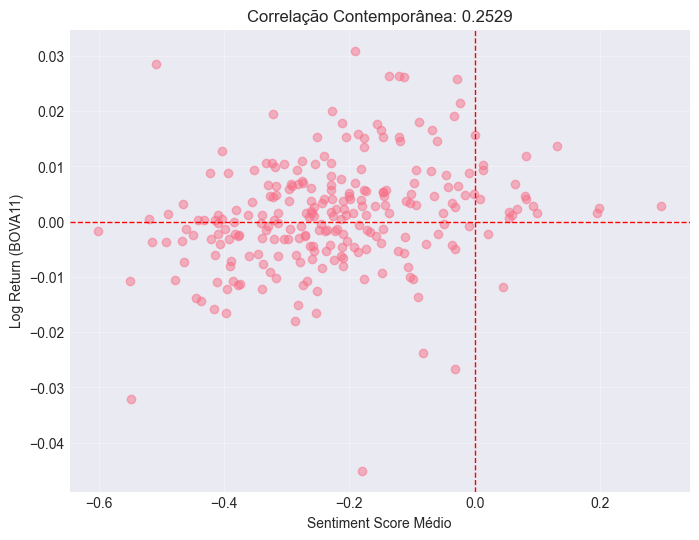

In [6]:
# Correlação entre sentimento e retorno no mesmo dia
corr_t0 = df_final[['sentiment_mean', 'Log_Return']].corr()

print("Correlação Contemporânea (t vs t):")
print(f"\nsentiment_mean vs Log_Return: {corr_t0.iloc[0, 1]:.4f}")

# Visualização
plt.figure(figsize=(8, 6))
plt.scatter(df_final['sentiment_mean'], df_final['Log_Return'], alpha=0.5)
plt.xlabel('Sentiment Score Médio')
plt.ylabel('Log Return (BOVA11)')
plt.title(f'Correlação Contemporânea: {corr_t0.iloc[0, 1]:.4f}')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)
plt.show()

### 5.2 Correlação com Diferentes Lags

Correlação entre Sentimento(t) e Retorno(t+lag):
   lag                           description  correlation  sample_size
0    0    sentiment_mean(t) vs Log_Return(t)     0.252892          247
1    1  sentiment_mean(t) vs Log_Return(t+1)     0.032052          246
2    2  sentiment_mean(t) vs Log_Return(t+2)    -0.038978          245
3    3  sentiment_mean(t) vs Log_Return(t+3)    -0.068207          244
4    4  sentiment_mean(t) vs Log_Return(t+4)     0.005716          243
5    5  sentiment_mean(t) vs Log_Return(t+5)    -0.023648          242


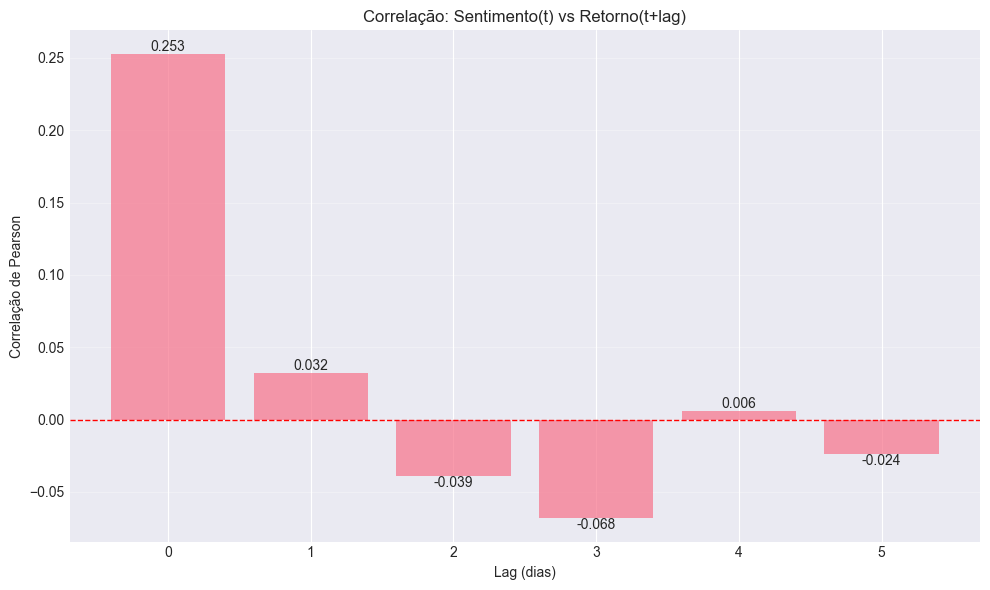

In [7]:
# Calcular correlações para diferentes lags
correlation_results = calculate_sentiment_correlation(
    df=df_final,
    sentiment_col='sentiment_mean',
    return_col='Log_Return',
    max_lag=5
)

print("Correlação entre Sentimento(t) e Retorno(t+lag):")
print(correlation_results)

# Visualização
plt.figure(figsize=(10, 6))
plt.bar(correlation_results['lag'], correlation_results['correlation'], alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Lag (dias)')
plt.ylabel('Correlação de Pearson')
plt.title('Correlação: Sentimento(t) vs Retorno(t+lag)')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(correlation_results['lag'])

# Adicionar valores nos topos das barras
for idx, row in correlation_results.iterrows():
    plt.text(row['lag'], row['correlation'], f"{row['correlation']:.3f}",
             ha='center', va='bottom' if row['correlation'] > 0 else 'top')

plt.tight_layout()
plt.show()

### 5.3 Matriz de Correlação (Todas as Variáveis)

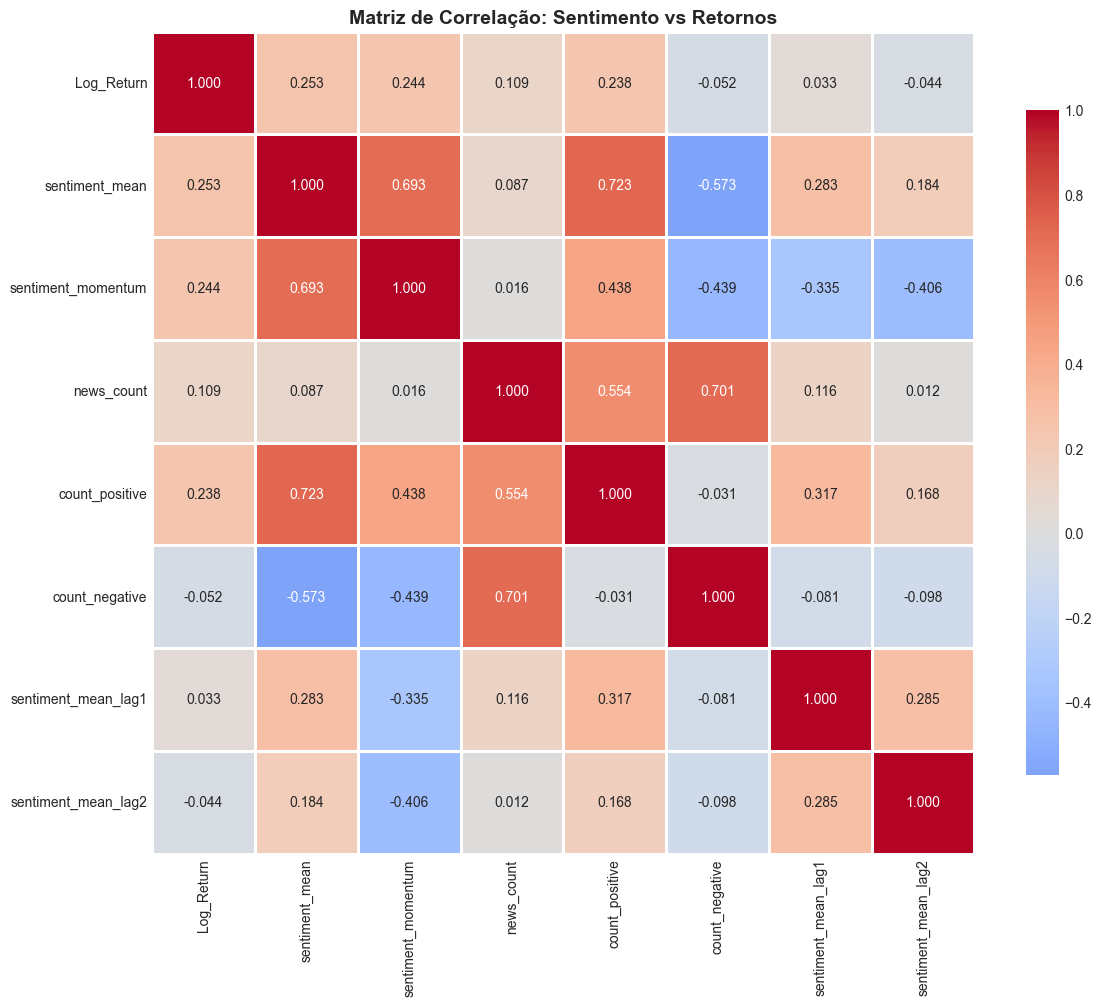


Correlações com Log_Return (ordenadas):
sentiment_mean         0.252892
sentiment_momentum     0.244209
count_positive         0.238366
news_count             0.109005
sentiment_mean_lag1    0.033324
sentiment_mean_lag2   -0.043728
count_negative        -0.051521
Name: Log_Return, dtype: float64


In [8]:
# Selecionar colunas relevantes para correlação
correlation_cols = [
    'Log_Return',
    'sentiment_mean',
    'sentiment_momentum',
    'news_count',
    'count_positive',
    'count_negative',
    'sentiment_mean_lag1',
    'sentiment_mean_lag2'
]

# Calcular matriz de correlação
corr_matrix = df_final[correlation_cols].corr()

# Visualização
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)
plt.title('Matriz de Correlação: Sentimento vs Retornos', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Mostrar correlações com Log_Return em ordem decrescente
print("\nCorrelações com Log_Return (ordenadas):")
log_return_corr = corr_matrix['Log_Return'].drop('Log_Return').sort_values(ascending=False)
print(log_return_corr)

## 6. Análise Temporal Combinada

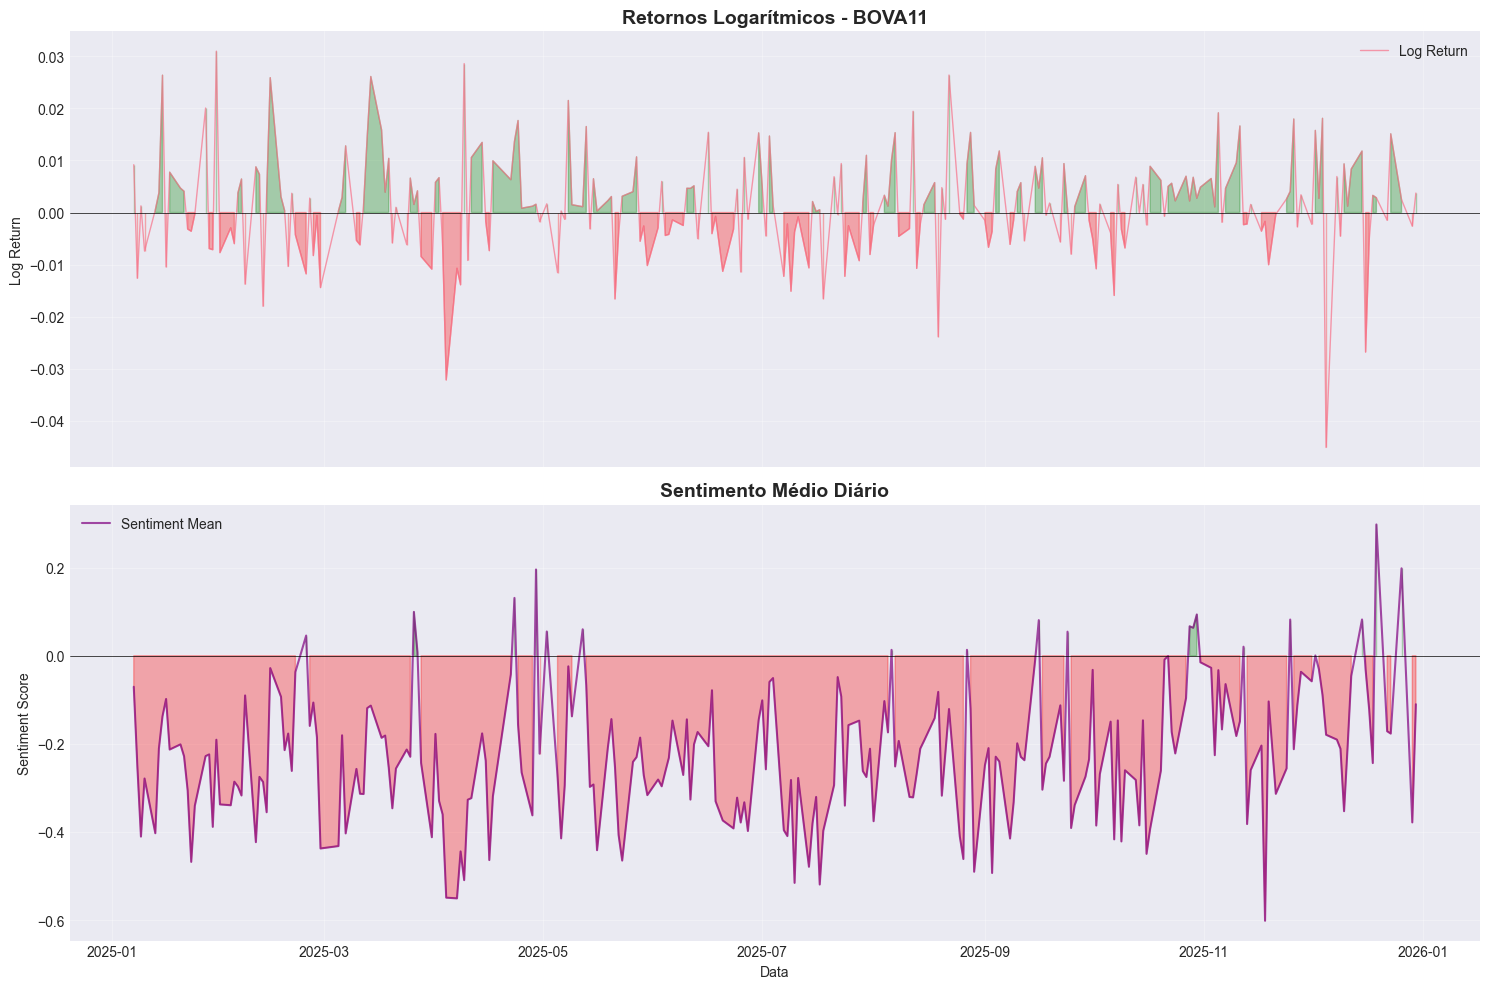

 Observe visualmente se há períodos onde sentimento e retorno se movem juntos!


In [9]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Gráfico 1: Retornos do BOVA11
axes[0].plot(df_final['date'], df_final['Log_Return'], linewidth=1, alpha=0.7, label='Log Return')
axes[0].fill_between(
    df_final['date'],
    df_final['Log_Return'],
    0,
    where=(df_final['Log_Return'] > 0),
    alpha=0.3,
    color='green'
)
axes[0].fill_between(
    df_final['date'],
    df_final['Log_Return'],
    0,
    where=(df_final['Log_Return'] <= 0),
    alpha=0.3,
    color='red'
)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_title('Retornos Logarítmicos - BOVA11', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Log Return')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Gráfico 2: Sentimento Médio
axes[1].plot(df_final['date'], df_final['sentiment_mean'], linewidth=1.5, 
             alpha=0.7, color='purple', label='Sentiment Mean')
axes[1].fill_between(
    df_final['date'],
    df_final['sentiment_mean'],
    0,
    where=(df_final['sentiment_mean'] > 0),
    alpha=0.3,
    color='green'
)
axes[1].fill_between(
    df_final['date'],
    df_final['sentiment_mean'],
    0,
    where=(df_final['sentiment_mean'] <= 0),
    alpha=0.3,
    color='red'
)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_title('Sentimento Médio Diário', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Sentiment Score')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(" Observe visualmente se há períodos onde sentimento e retorno se movem juntos!")

## 7. Salvar Dataset Final

In [10]:
# Caminho do arquivo final
final_output_path = '../src/dataset/result/sentiment_returns_merged.csv'

# Salvar
df_final.to_csv(final_output_path, index=False)

print(f" Dataset final salvo em: {final_output_path}")
print(f"   Total de observações: {len(df_final)}")
print(f"   Total de variáveis: {len(df_final.columns)}")
print(f"   Período: {df_final['date'].min().date()} até {df_final['date'].max().date()}")

 Dataset final salvo em: ../src/dataset/result/sentiment_returns_merged.csv
   Total de observações: 247
   Total de variáveis: 35
   Período: 2025-01-07 até 2025-12-30


## 7. Análise de Regressão Linear (OLS)

Utilizamos regressão OLS (`statsmodels`) para quantificar a relação estatística entre o sentimento de notícias e os retornos do BOVA11.

---

In [11]:
import statsmodels.api as sm
from scipy import stats

# Preparar dados para regressão - remover NaN (criados pelos lags)
df_reg = df_final.dropna().copy()
print(f"Observações disponíveis para regressão: {len(df_reg)}")
print(f"Período: {df_reg['date'].min().date()} a {df_reg['date'].max().date()}")
print(f"\nVariáveis independentes disponíveis:")
print(f"  - sentiment_mean (sentimento contemporâneo)")
print(f"  - sentiment_mean_lag1")
print(f"  - sentiment_mean_lag2")


Observações disponíveis para regressão: 247
Período: 2025-01-07 a 2025-12-30

Variáveis independentes disponíveis:
  - sentiment_mean (sentimento contemporâneo)
  - sentiment_mean_lag1
  - sentiment_mean_lag2


### 7.1 Regressão Linear Simples: Sentimento(t) → Retorno(t)

Testamos a hipótese de que o sentimento das notícias no dia `t` explica o retorno do BOVA11 no mesmo dia.

In [12]:
# --- Regressão Simples: sentiment_mean -> Log_Return ---
X_simple = sm.add_constant(df_reg['sentiment_mean'])  # adiciona intercepto
y = df_reg['Log_Return']

model_simple = sm.OLS(y, X_simple).fit()
print(model_simple.summary())


                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     16.74
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           5.82e-05
Time:                        08:12:42   Log-Likelihood:                 802.16
No. Observations:                 247   AIC:                            -1600.
Df Residuals:                     245   BIC:                            -1593.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0048      0.001      4.

### 7.2 Visualização: Regressão Simples

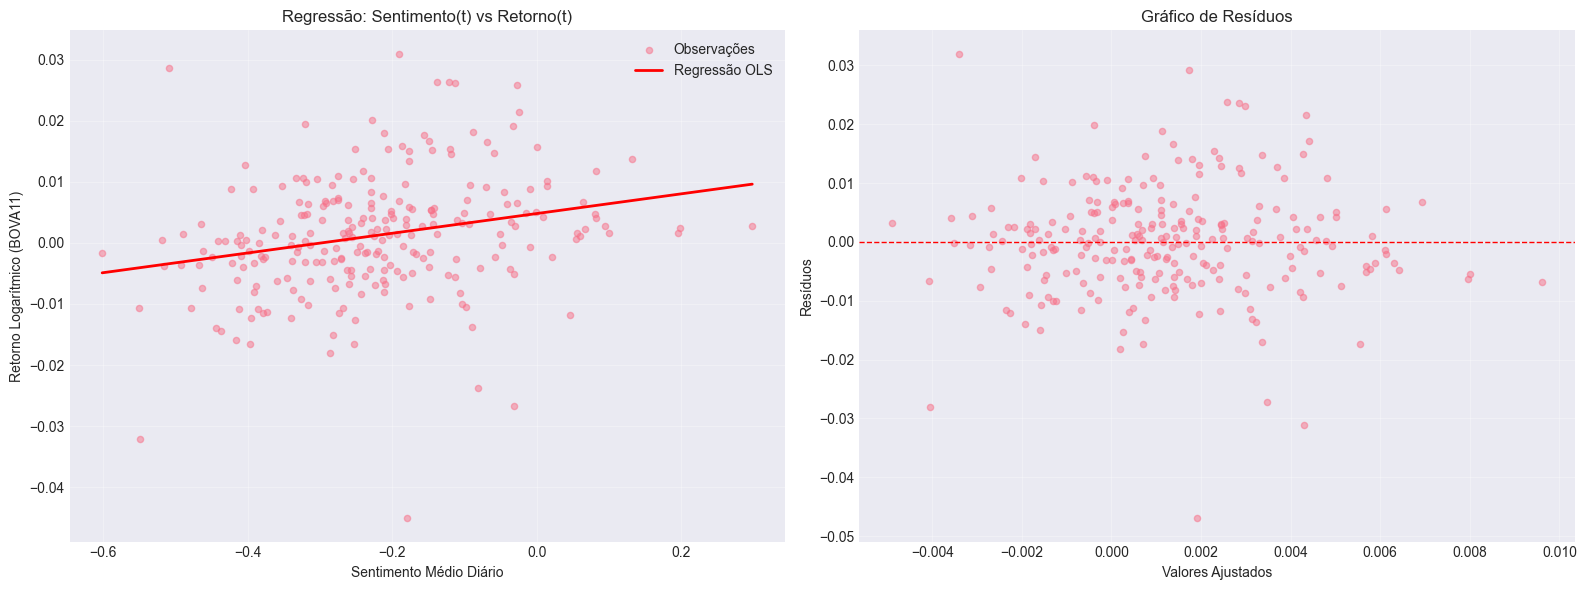

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot com linha de regressão
ax1 = axes[0]
ax1.scatter(df_reg['sentiment_mean'], df_reg['Log_Return'], alpha=0.5, s=20, label='Observações')
x_line = np.linspace(df_reg['sentiment_mean'].min(), df_reg['sentiment_mean'].max(), 100)
y_line = model_simple.params['const'] + model_simple.params['sentiment_mean'] * x_line
ax1.plot(x_line, y_line, color='red', linewidth=2, label='Regressão OLS')
ax1.set_xlabel('Sentimento Médio Diário')
ax1.set_ylabel('Retorno Logarítmico (BOVA11)')
ax1.set_title('Regressão: Sentimento(t) vs Retorno(t)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico de resíduos
ax2 = axes[1]
ax2.scatter(model_simple.fittedvalues, model_simple.resid, alpha=0.5, s=20)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax2.set_xlabel('Valores Ajustados')
ax2.set_ylabel('Resíduos')
ax2.set_title('Gráfico de Resíduos')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 7.3 Regressão Múltipla: Sentimento(t) + Lags → Retorno(t)

Incluímos variáveis defasadas (sentiment_mean_lag1, sentiment_mean_lag2) para verificar se o sentimento de dias anteriores tem poder preditivo sobre o retorno atual.

In [14]:
# --- Regressão Múltipla ---
features = ['sentiment_mean', 'sentiment_mean_lag1', 'sentiment_mean_lag2']
X_multi = sm.add_constant(df_reg[features])
y = df_reg['Log_Return']

model_multi = sm.OLS(y, X_multi).fit()
print(model_multi.summary())


                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     6.349
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           0.000368
Time:                        08:12:43   Log-Likelihood:                 803.31
No. Observations:                 247   AIC:                            -1599.
Df Residuals:                     243   BIC:                            -1585.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0036    

### 7.4 Teste de Correlação de Pearson (com p-valor)

Teste estatístico formal para verificar a significância da correlação.

In [15]:
print('=' * 60)
print('TESTE DE CORRELAÇÃO DE PEARSON')
print('=' * 60)

corr, pval = stats.pearsonr(df_reg['sentiment_mean'], df_reg['Log_Return'])
sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
print(f"sentiment_mean                 -> r = {corr:+.4f}, p = {pval:.4f} {sig}")

corr, pval = stats.pearsonr(df_reg['sentiment_mean_lag1'], df_reg['Log_Return'])
sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
print(f"sentiment_mean_lag1            -> r = {corr:+.4f}, p = {pval:.4f} {sig}")

corr, pval = stats.pearsonr(df_reg['sentiment_mean_lag2'], df_reg['Log_Return'])
sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
print(f"sentiment_mean_lag2            -> r = {corr:+.4f}, p = {pval:.4f} {sig}")

print('\n--- Legenda: *** p<0.01, ** p<0.05, * p<0.10 ---')


TESTE DE CORRELAÇÃO DE PEARSON
sentiment_mean                 -> r = +0.2529, p = 0.0001 ***
sentiment_mean_lag1            -> r = +0.0333, p = 0.6022 
sentiment_mean_lag2            -> r = -0.0437, p = 0.4939 

--- Legenda: *** p<0.01, ** p<0.05, * p<0.10 ---


### 7.5 Resumo dos Resultados da Regressão

Consolidação das métricas estatísticas para o TCC.

In [16]:
# --- Resumo Comparativo ---
print('=' * 70)
print('RESUMO DOS MODELOS DE REGRESSÃO')
print('=' * 70)

print(f"\n{'Modelo':<40} {'R²':>8} {'R² Adj':>8} {'F-stat':>10} {'p(F)':>12}")
print('-' * 78)

print(f"{'Simples (sentiment_mean)':<40} {model_simple.rsquared:>8.4f} {model_simple.rsquared_adj:>8.4f} {model_simple.fvalue:>10.4f} {model_simple.f_pvalue:>12.4e}")
print(f"{'Múltipla (sentiment + lags)':<40} {model_multi.rsquared:>8.4f} {model_multi.rsquared_adj:>8.4f} {model_multi.fvalue:>10.4f} {model_multi.f_pvalue:>12.4e}")

print('\n' + '=' * 70)
print('COEFICIENTES DO MODELO SIMPLES')
print('=' * 70)
for param_name, coef in model_simple.params.items():
    pval = model_simple.pvalues[param_name]
    sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
    print(f"  {param_name:<30} coef = {coef:+.6f}  p = {pval:.4f} {sig}")

print('\n' + '=' * 70)
print('COEFICIENTES DO MODELO MÚLTIPLO')
print('=' * 70)
for param_name, coef in model_multi.params.items():
    pval = model_multi.pvalues[param_name]
    sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
    print(f"  {param_name:<30} coef = {coef:+.6f}  p = {pval:.4f} {sig}")

print('\n--- Legenda: *** p<0.01, ** p<0.05, * p<0.10 ---')


RESUMO DOS MODELOS DE REGRESSÃO

Modelo                                         R²   R² Adj     F-stat         p(F)
------------------------------------------------------------------------------
Simples (sentiment_mean)                   0.0640   0.0601    16.7394   5.8227e-05
Múltipla (sentiment + lags)                0.0727   0.0612     6.3491   3.6807e-04

COEFICIENTES DO MODELO SIMPLES
  const                          coef = +0.004804  p = 0.0000 ***
  sentiment_mean                 coef = +0.016134  p = 0.0001 ***

COEFICIENTES DO MODELO MÚLTIPLO
  const                          coef = +0.003579  p = 0.0101 **
  sentiment_mean                 coef = +0.017517  p = 0.0000 ***
  sentiment_mean_lag1            coef = -0.001212  p = 0.7754 
  sentiment_mean_lag2            coef = -0.005672  p = 0.1723 

--- Legenda: *** p<0.01, ** p<0.05, * p<0.10 ---


### 7.6 Teste de Estacionariedade (Augmented Dickey-Fuller)

Antes de confiar nos resultados de correlacao e regressao com series temporais, precisamos verificar se as series sao **estacionarias**.
Se nao forem, a correlacao encontrada pode ser **espuria** (falsa).

- **H0**: A serie possui raiz unitaria (nao e estacionaria)
- **H1**: A serie e estacionaria
- **Criterio**: Se `p-valor < 0.05`, rejeitamos H0 -> serie e estacionaria

In [17]:
from statsmodels.tsa.stattools import adfuller

def run_adf_test(series, name):
    """Executa o teste ADF e imprime os resultados formatados."""
    result = adfuller(series.dropna(), autolag='AIC')
    adf_stat = result[0]
    p_value = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_values = result[4]
    
    status = 'ESTACIONARIA' if p_value < 0.05 else 'NAO ESTACIONARIA'
    
    print(f"\n{'='*60}")
    print(f"Teste ADF: {name}")
    print(f"{'='*60}")
    print(f"  Estatistica ADF : {adf_stat:.6f}")
    print(f"  p-valor         : {p_value:.6f}")
    print(f"  Lags utilizados : {used_lag}")
    print(f"  Observacoes     : {n_obs}")
    print(f"  Valores Criticos:")
    for key, val in critical_values.items():
        print(f"    {key}: {val:.6f}")
    print(f"\n  -> Resultado: {status}")
    
    return p_value < 0.05

# Testar as series principais
print('TESTES DE ESTACIONARIEDADE (ADF)')
print('Criterio: p-valor < 0.05 -> serie estacionaria')

is_return_stationary = run_adf_test(df_reg['Log_Return'], 'Log_Return (Retorno BOVA11)')
is_sentiment_stationary = run_adf_test(df_reg['sentiment_mean'], 'sentiment_mean (Sentimento Diario)')

# Se sentimento nao for estacionario, criar e testar a diferenca
if not is_sentiment_stationary:
    print('\n' + '!'*60)
    print('ATENCAO: sentiment_mean NAO e estacionaria!')
    print('Criando serie diferenciada: d_sentiment = sentiment(t) - sentiment(t-1)')
    print('!'*60)
    
    df_reg['sentiment_diff'] = df_reg['sentiment_mean'].diff()
    is_diff_stationary = run_adf_test(df_reg['sentiment_diff'].dropna(), 'd_sentiment_mean (Diferenca do Sentimento)')
    
    if is_diff_stationary:
        print('\nA serie diferenciada E estacionaria. Resultados de correlacao/regressao sao confiaveis.')
    else:
        print('\nMesmo a serie diferenciada nao e estacionaria. Cuidado com interpretacoes.')
else:
    print('\nAmbas as series sao estacionarias. Resultados de correlacao/regressao sao confiaveis.')


TESTES DE ESTACIONARIEDADE (ADF)
Criterio: p-valor < 0.05 -> serie estacionaria

Teste ADF: Log_Return (Retorno BOVA11)
  Estatistica ADF : -16.950322
  p-valor         : 0.000000
  Lags utilizados : 0
  Observacoes     : 246
  Valores Criticos:
    1%: -3.457215
    5%: -2.873362
    10%: -2.573070

  -> Resultado: ESTACIONARIA

Teste ADF: sentiment_mean (Sentimento Diario)
  Estatistica ADF : -5.167900
  p-valor         : 0.000010
  Lags utilizados : 4
  Observacoes     : 242
  Valores Criticos:
    1%: -3.457664
    5%: -2.873559
    10%: -2.573175

  -> Resultado: ESTACIONARIA

Ambas as series sao estacionarias. Resultados de correlacao/regressao sao confiaveis.


### 7.7 Teste de Causalidade de Granger

O teste de Granger avalia se uma serie temporal **ajuda a prever** outra.
Testamos nas **duas direcoes**:

1. **Sentimento -> Retorno**: O sentimento das noticias antecipa os retornos do mercado?
2. **Retorno -> Sentimento**: Os retornos do mercado influenciam o sentimento das noticias?

- **H0**: A serie X **nao** Granger-causa Y
- **Criterio**: Se `p-valor < 0.05`, rejeitamos H0 -> X Granger-causa Y

> **Importante**: Se provarmos que Sentimento -> Retorno (p < 0.05), isso da suporte a hipotese central do TCC.

In [18]:
from statsmodels.tsa.stattools import grangercausalitytests

max_lags = 5  # Testar de 1 a 5 lags

# Preparar dados sem NaN
df_granger = df_reg[['Log_Return', 'sentiment_mean']].dropna()

# --- Teste 1: Sentimento -> Retorno ---
print('=' * 70)
print('TESTE DE GRANGER: Sentimento -> Retorno')
print('H0: sentiment_mean NAO Granger-causa Log_Return')
print('=' * 70)
# grangercausalitytests espera [Y, X] onde testamos se X causa Y
gc_sent_to_ret = grangercausalitytests(df_granger[['Log_Return', 'sentiment_mean']], maxlag=max_lags, verbose=True)

print('\n')

# --- Teste 2: Retorno -> Sentimento ---
print('=' * 70)
print('TESTE DE GRANGER: Retorno -> Sentimento')
print('H0: Log_Return NAO Granger-causa sentiment_mean')
print('=' * 70)
gc_ret_to_sent = grangercausalitytests(df_granger[['sentiment_mean', 'Log_Return']], maxlag=max_lags, verbose=True)


TESTE DE GRANGER: Sentimento -> Retorno
H0: sentiment_mean NAO Granger-causa Log_Return

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7178  , p=0.3977  , df_denom=243, df_num=1
ssr based chi2 test:   chi2=0.7267  , p=0.3940  , df=1
likelihood ratio test: chi2=0.7256  , p=0.3943  , df=1
parameter F test:         F=0.7178  , p=0.3977  , df_denom=243, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7842  , p=0.4576  , df_denom=240, df_num=2
ssr based chi2 test:   chi2=1.6011  , p=0.4491  , df=2
likelihood ratio test: chi2=1.5959  , p=0.4503  , df=2
parameter F test:         F=0.7842  , p=0.4576  , df_denom=240, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7428  , p=0.5275  , df_denom=237, df_num=3
ssr based chi2 test:   chi2=2.2942  , p=0.5136  , df=3
likelihood ratio test: chi2=2.2834  , p=0.5157  , df=3
parameter F test:         F=0.7428  , p=0.5275  , df_denom=237, df_num=3

Grang

d:\dev\mba-tcc\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\dev\mba-tcc\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [19]:
# --- Resumo do Teste de Granger ---
print('\n' + '=' * 70)
print('RESUMO: CAUSALIDADE DE GRANGER')
print('=' * 70)
print(f"{'Direcao':<35} {'Lag':>4} {'F-stat':>10} {'p-valor':>10} {'Sig':>5}")
print('-' * 70)

for lag in range(1, max_lags + 1):
    # Sentimento -> Retorno
    f_stat_sr = gc_sent_to_ret[lag][0]['ssr_ftest'][0]
    p_val_sr = gc_sent_to_ret[lag][0]['ssr_ftest'][1]
    sig_sr = '***' if p_val_sr < 0.01 else ('**' if p_val_sr < 0.05 else ('*' if p_val_sr < 0.1 else ''))
    print(f"{'Sentimento -> Retorno':<35} {lag:>4} {f_stat_sr:>10.4f} {p_val_sr:>10.4f} {sig_sr:>5}")

print('-' * 70)

for lag in range(1, max_lags + 1):
    # Retorno -> Sentimento
    f_stat_rs = gc_ret_to_sent[lag][0]['ssr_ftest'][0]
    p_val_rs = gc_ret_to_sent[lag][0]['ssr_ftest'][1]
    sig_rs = '***' if p_val_rs < 0.01 else ('**' if p_val_rs < 0.05 else ('*' if p_val_rs < 0.1 else ''))
    print(f"{'Retorno -> Sentimento':<35} {lag:>4} {f_stat_rs:>10.4f} {p_val_rs:>10.4f} {sig_rs:>5}")

print('\n--- Legenda: *** p<0.01, ** p<0.05, * p<0.10 ---')



RESUMO: CAUSALIDADE DE GRANGER
Direcao                              Lag     F-stat    p-valor   Sig
----------------------------------------------------------------------
Sentimento -> Retorno                  1     0.7178     0.3977      
Sentimento -> Retorno                  2     0.7842     0.4576      
Sentimento -> Retorno                  3     0.7428     0.5275      
Sentimento -> Retorno                  4     0.6504     0.6271      
Sentimento -> Retorno                  5     0.5149     0.7649      
----------------------------------------------------------------------
Retorno -> Sentimento                  1    11.5495     0.0008   ***
Retorno -> Sentimento                  2     6.5494     0.0017   ***
Retorno -> Sentimento                  3     4.5275     0.0042   ***
Retorno -> Sentimento                  4     3.4663     0.0090   ***
Retorno -> Sentimento                  5     2.7358     0.0201    **

--- Legenda: *** p<0.01, ** p<0.05, * p<0.10 ---


### 7.8 Correlacao Movel (Rolling Correlation)

A correlacao media anual pode esconder variacoes importantes ao longo do tempo.
Em periodos de crise, a correlacao tende a ser mais forte.

Calculamos a correlacao em **janelas moveis de 30 dias** para visualizar como a relacao entre sentimento e retorno varia ao longo do ano.

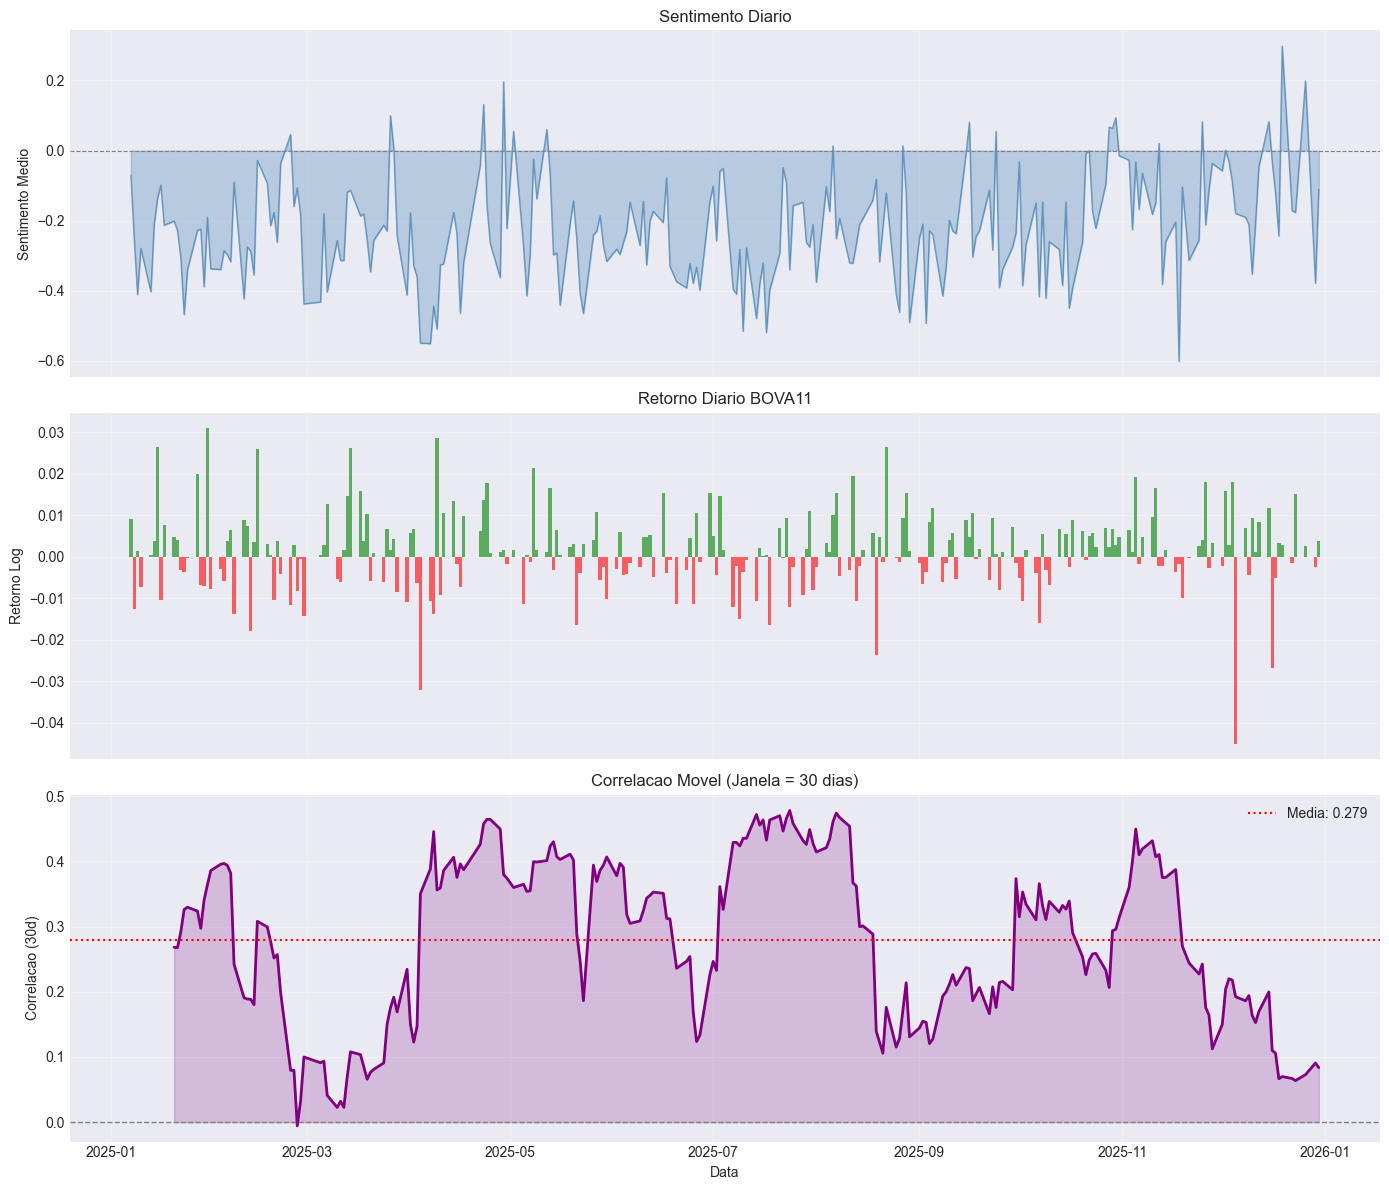


Estatisticas da Correlacao Movel (30 dias):
  Media     : +0.2787
  Mediana   : +0.2966
  Minimo    : -0.0057
  Maximo    : +0.4782
  Std       : 0.1242
  %% dias>0 : 99.6%%


In [ ]:
# --- Correlacao Movel (Rolling Window = 30 dias) ---
window = 30

df_rolling = df_reg[['date', 'sentiment_mean', 'Log_Return']].copy()
df_rolling = df_rolling.set_index('date').sort_index()

# Calcular correlacao movel
rolling_corr = df_rolling['sentiment_mean'].rolling(window=window, min_periods=10).corr(df_rolling['Log_Return'])

# Visualizacao
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# 1. Sentimento ao longo do tempo
ax1 = axes[0]
ax1.plot(df_rolling.index, df_rolling['sentiment_mean'], color='steelblue', linewidth=1, alpha=0.7)
ax1.fill_between(df_rolling.index, df_rolling['sentiment_mean'], alpha=0.3, color='steelblue')
ax1.set_ylabel('Sentimento Médio')
ax1.set_title('Sentimento Diário')
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
ax1.grid(True, alpha=0.3)

# 2. Retorno ao longo do tempo
ax2 = axes[1]
colors = ['green' if v >= 0 else 'red' for v in df_rolling['Log_Return']]
ax2.bar(df_rolling.index, df_rolling['Log_Return'], color=colors, alpha=0.6, width=1)
ax2.set_ylabel('Retorno Log')
ax2.set_title('Retorno Diário BOVA11')
ax2.grid(True, alpha=0.3)

# 3. Correlacao Movel
ax3 = axes[2]
ax3.plot(rolling_corr.index, rolling_corr.values, color='purple', linewidth=2)
ax3.fill_between(rolling_corr.index, rolling_corr.values, alpha=0.2, color='purple')
ax3.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax3.axhline(y=rolling_corr.mean(), color='red', linestyle=':', linewidth=1.5, label=f'Media: {rolling_corr.mean():.3f}')
ax3.set_ylabel(f'Correlação ({window}d)')
ax3.set_xlabel('Data')
ax3.set_title(f'Correlação Movel (Janela = {window} dias)')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatisticas da correlacao movel
print(f'\nEstatisticas da Correlacao Movel ({window} dias):')
print(f'  Media     : {rolling_corr.mean():+.4f}')
print(f'  Mediana   : {rolling_corr.median():+.4f}')
print(f'  Minimo    : {rolling_corr.min():+.4f}')
print(f'  Maximo    : {rolling_corr.max():+.4f}')
print(f'  Std       : {rolling_corr.std():.4f}')
print(f'  %% dias>0 : {(rolling_corr > 0).sum() / rolling_corr.notna().sum() * 100:.1f}%%')
